## O objetivo desse trabalho é treinar um algoritmo de aprendizado de máquina para resolver um problema de classificação binária.

### O conjunto de dados de treino é composto por 14000 textos pertencentes a duas classes: "não sexista" e "sexista" (0, 1). O conjunto de dados de teste é composto por 4000 textos.


### Como veremos a seguir, estes dados estão desbalanceados. Portanto serão aplicadas técnicas de balanceamento de classes além de outros processamentos específicos com o objetivo de melhorar o desempenho do modelo.


#### O conjunto de dados (dataset) utilizado está disponível neste link: https://www.kaggle.com/datasets/aadyasingh55/sexism-detection-in-english-texts


#### De forma mais abrangente, esse trabalho representa o início dos meus estudos práticos no campo de NLP (Natural Language Processing).

# Considerações iniciais:
- Os textos não sexistas serão classificados como 0, portanto os textos sexistas serão classificados como 1. Analisando o cenário proposto, irei considerar que o caso mais danoso acontece quando há um falso negativo, ou seja, um texto sexista é classificado como não sexista, passando pelo "filtro". Portanto a métrica Sensibilidade (Recall) é chave para esse problema, pois é inversamente proporcional ao número de falsos negativos.

In [ ]:
# importação das bibliotecas utilizadas no trabalho
import pandas as pd
import numpy as np
import os
import re

#NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

# utilidades
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# algoritmos de ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# métricas
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             classification_report)
# visualização
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Baixando algumas utilidades e definindopadrões

#tokenizando
nltk.download('punkt')
nltk.download('punkt_tab')
#lista de stop-words
nltk.download('stopwords')
#stemming
nltk.download('rslp')
#lematização with nltk
nltk.download('wordnet')

stemmer = nltk.stem.RSLPStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Removendo alguns termos da lista de stopwords a serem excluídas.
stop_words = stopwords.words('english')
stop_words.remove('she')
stop_words.remove('her')

#### Definindo as funções utilizadas no trabalho.
- Esta seção contém as funções de pipeline e de utilidades variadas.

In [ ]:
# Definindo as funções utilizadas nesta seção:
# Pipelines com dados de treino
def pipeline_base(classificadores: dict,
                  df_resultados: pd.DataFrame,
                  X: pd.Series,
                  y: pd.Series,) -> pd.DataFrame:
  '''
  Roda a pipeline definida com os algoritmos instanciados em um dict.
  retorna um dataframe pandas com os resultados.
  '''

  rng = np.random.RandomState(SEED)

  # Insere um sufixo para diferenciar os clasificadores em cada pipeline
  classificadores = muda_sufixo_classificadores(classificadores=classificadores,
                                               sufixo='_base')

  for nome, classificador in classificadores.items():
      pipeline = Pipeline([
          ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
          ('classificador', classificador)
      ])

      # Separando os dados de treino e teste usando estratificação
      X_train, X_test, y_train, y_test = dados_split(X, y)

      # Treinando o modelo
      pipeline.fit(X_train, y_train)
      # Fazendo as predições
      y_pred = pipeline.predict(X_test)

      # Calculando as métricas
      acc, f1_0, f1_1, matriz_conf, tn, fp, fn, tp = calc_metricas(y_test,
                                                                   y_pred)

      resultado_parcial = pd.DataFrame([{
          'algoritmo': nome,
          'acurácia': acc,
          'f1-score_0': f1_0,
          'f1-score_1': f1_1,
          'matriz_confusao': matriz_conf,
          'tn': tn,
          'fp': fp,
          'fn': fn,
          'tp': tp,
      }])

      df_resultados = pd.concat([df_resultados, resultado_parcial], ignore_index=True)

  return df_resultados


def pipeline_undersampler(classificadores: dict,
                  df_resultados: pd.DataFrame,
                  X: pd.Series,
                  y: pd.Series,) -> pd.DataFrame:
  '''
  Roda a pipeline definida com os algoritmos instanciados em um dict.
  retorna um dataframe pandas com os resultados.
  '''

  rng = np.random.RandomState(SEED)

  # Insere um sufixo para diferenciar os clasificadores em cada pipeline
  classificadores = muda_sufixo_classificadores(classificadores=classificadores,
                                                sufixo='_under')

  for nome, classificador in classificadores.items():
      pipeline = ImbPipeline([
          ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
          ('random_undersampler', RandomUnderSampler(sampling_strategy='majority',
                                                     random_state=SEED)),
          ('classificador', classificador)
      ])

      # Separando os dados de treino e teste usando estratificação
      X_train, X_test, y_train, y_test = dados_split(X, y)

      # Treinando o modelo
      pipeline.fit(X_train, y_train)
      # Fazendo as predições
      y_pred = pipeline.predict(X_test)

      # Calculando as métricas
      acc, f1_0, f1_1, matriz_conf, tn, fp, fn, tp = calc_metricas(y_test,
                                                                   y_pred)

      resultado_parcial = pd.DataFrame([{
          'algoritmo': nome,
          'acurácia': acc,
          'f1-score_0': f1_0,
          'f1-score_1': f1_1,
          'matriz_confusao': matriz_conf,
          'tn': tn,
          'fp': fp,
          'fn': fn,
          'tp': tp,
      }])

      df_resultados = pd.concat([df_resultados, resultado_parcial], ignore_index=True)

  return df_resultados

def pipeline_oversampler(classificadores: dict,
                  df_resultados: pd.DataFrame,
                  X: pd.Series,
                  y: pd.Series,) -> pd.DataFrame:
  '''
  Roda a pipeline definida com os algoritmos instanciados em um dict.
  retorna um dataframe pandas com os resultados.
  '''

  rng = np.random.RandomState(SEED)

  # Insere um sufixo para diferenciar os clasificadores em cada pipeline
  classificadores = muda_sufixo_classificadores(classificadores=classificadores,
                                                sufixo='_over')

  for nome, classificador in classificadores.items():
      pipeline = ImbPipeline([
          ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
          ('smote', SMOTE(sampling_strategy=0.8, random_state=SEED)),
          ('classificador', classificador)
      ])

      # Separando os dados de treino e teste usando estratificação
      X_train, X_test, y_train, y_test = dados_split(X, y)

      # Treinando o modelo
      pipeline.fit(X_train, y_train)
      # Fazendo as predições
      y_pred = pipeline.predict(X_test)

      # Calculando as métricas
      acc, f1_0, f1_1, matriz_conf, tn, fp, fn, tp = calc_metricas(y_test,
                                                                   y_pred)

      resultado_parcial = pd.DataFrame([{
          'algoritmo': nome,
          'acurácia': acc,
          'f1-score_0': f1_0,
          'f1-score_1': f1_1,
          'matriz_confusao': matriz_conf,
          'tn': tn,
          'fp': fp,
          'fn': fn,
          'tp': tp,
      }])

      df_resultados = pd.concat([df_resultados, resultado_parcial], ignore_index=True)

  return df_resultados


# Pipelines com dados de teste
def pipeline_oversampler_teste(classificadores: dict,
                  df_resultados: pd.DataFrame,
                  X_treino: pd.Series,
                  y_treino: pd.Series,
                  X_teste: pd.Series,
                  y_teste: pd.Series,) -> pd.DataFrame:
  '''
  Roda a pipeline definida com os algoritmos instanciados em um dict.
  retorna um dataframe pandas com os resultados.
  '''

  rng = np.random.RandomState(SEED)

  # Insere um sufixo para diferenciar os clasificadores em cada pipeline
  classificadores = muda_sufixo_classificadores(classificadores=classificadores,
                                                sufixo='_over')

  for nome, classificador in classificadores.items():
      pipeline = ImbPipeline([
          ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
          ('smote', SMOTE(sampling_strategy=0.8, random_state=SEED)),
          ('classificador', classificador)
      ])

      # Treinando o modelo
      pipeline.fit(X_treino, y_treino)
      # Fazendo as predições
      y_pred = pipeline.predict(X_teste)

      # Calculando as métricas
      acc, f1_0, f1_1, matriz_conf, tn, fp, fn, tp = calc_metricas(y_teste,
                                                                   y_pred)

      resultado_parcial = pd.DataFrame([{
          'algoritmo': nome,
          'acurácia': acc,
          'f1-score_0': f1_0,
          'f1-score_1': f1_1,
          'matriz_confusao': matriz_conf,
          'tn': tn,
          'fp': fp,
          'fn': fn,
          'tp': tp,
      }])

      df_resultados = pd.concat([df_resultados, resultado_parcial], ignore_index=True)

  return df_resultados


# Utilidades

# Definindo as funções de pré-processamento dos textos
def clean_text(text: str) -> pd.Series:

  processed_text = text.lower()
  processed_text = re.sub('[^A-Za-z0-9]+', ' ', processed_text)
  processed_text = nltk.word_tokenize(processed_text)
  processed_text = [word for word in processed_text if word not in stop_words]
  processed_text = [lemmatizer.lemmatize(word) for word in processed_text]
  tokenized = processed_text
  processed_text = ' '.join(processed_text)

  return pd.Series([tokenized, processed_text])


def dados_split(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                      random_state=SEED,
                                                      stratify=y)
  return X_train, X_test, y_train, y_test


def calc_metricas(y_test, y_pred):
  acc = accuracy_score(y_test, y_pred)
  f1_0 = f1_score(y_test, y_pred, pos_label=0, average='binary')
  f1_1 = f1_score(y_test, y_pred, pos_label=1, average='binary')
  matriz_conf = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = matriz_conf.ravel()

  return acc, f1_0, f1_1, matriz_conf, tn, fp, fn, tp


def muda_sufixo_classificadores(classificadores: dict, sufixo: str) -> dict:
  '''Adiciona um sufixo às chaves de um dict. Cria um novo dict.'''
  return {chave + sufixo: valor for chave, valor in classificadores.items()}


# Função que calcula os moelhores hiperparâmetros com mbase em Randomized Search
def randomized_search_alt(classificador, parametros, n_testes, X, y):
  '''
  Para um classificador, esta função testa o conjunto de parâmetros
  definidos através de um dict.
  '''

  rng = np.random.RandomState(SEED)

  # Separando subconjuntos de treino e teste. (usando apenas o conjunto de treino)

  X_treino, X_teste, y_treino, y_teste = dados_split(X, y)

  # vetorizando os dados de trino e teste
  vectorizer_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
  X_treino_tfidf = vectorizer_tfidf.fit_transform(X_treino)
  X_teste_tfidf = vectorizer_tfidf.fit_transform(X_teste)

  # Instanciando o algoritmo de randomized search e definindo os parâmetros
  randomized_search = RandomizedSearchCV(
    estimator=classificador,
    param_distributions=parametros,
    n_iter=n_testes,  # Número de combinações aleatórias testadas
    scoring='f1_macro',  # métrica de validação
    cv=4,  # validação cruzada
    verbose=1,  # exibir logs
    random_state=SEED,
    n_jobs=-1  # utilizar todos os processadores disponíveis
  )

  randomized_search.fit(X_treino_tfidf, y_treino)

  # Obtendo os melhores parâmetros encontrados
  melhores_parametros = randomized_search.best_params_

  # Avaliar o melhor modelo segundo a métrica definida
  best_model = randomized_search.best_estimator_
  f1_score_micro = best_model.score(X_teste_tfidf, y_teste)

  return melhores_parametros, best_model


# contador de palavras nos textos. Separa as classes e conta a frequencia de
# palavras em cada um dos grupos.
def conta_palavras(df: pd.DataFrame, coluna: str) -> Counter:
    '''
    Conta a frequencia de palavras nos subconjuntos de textos da classe 0
    e da classe 1. Remove os pronomes "she" e "her", que são stop words.
    '''

    texto_unico = " ".join(df[df['target'] == 0]['clean_text']).split()
    # removendo os pronomes "she" e "her"
    texto_unico = [x for x in texto_unico if x not in ['she', 'her']]
    texto_unico = " ".join(texto_unico)
    palavras = re.findall(r'\b\w+\b', texto_unico)
    contagem_palavras_0 = Counter(palavras)

    texto_unico = " ".join(df[df['target'] == 1]['clean_text']).split()
    texto_unico = [x for x in texto_unico if x not in ['she', 'her']]
    texto_unico = " ".join(texto_unico)
    palavras = re.findall(r'\b\w+\b', texto_unico)
    contagem_palavras_1 = Counter(palavras)

    return contagem_palavras_0, contagem_palavras_1

## Explorando os dados de treino

In [ ]:
# Carregando os dados de treino e visualizando algumas de suas características.
df = pd.read_csv('train.csv')
df.sample(5)

,rewire_id,text,label_sexist,label_category,label_vector,split
11723,sexism2022_english-1314,Wake up America. Every time this ignored the e...,not sexist,none,none,train
6626,sexism2022_english-15179,I am sorry but in all places in man's world it...,not sexist,none,none,train
8413,sexism2022_english-1199,Why see a movie that even with normie values w...,not sexist,none,none,train
3558,sexism2022_english-19299,[URL] uk ones are dykes and look like hags,sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,...",train
324,sexism2022_english-2735,[USER] Do you know Christopher Cantwell? Your ...,not sexist,none,none,train


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       14000 non-null  object
 1   text            14000 non-null  object
 2   label_sexist    14000 non-null  object
 3   label_category  14000 non-null  object
 4   label_vector    14000 non-null  object
 5   split           14000 non-null  object
dtypes: object(6)
memory usage: 656.4+ KB


In [ ]:
# Observando a variável target "label_sexist"
print('número total de registros', df.shape[0])
print('número de registros das classes 0 e 1: ', df['label_sexist'].value_counts(normalize=False).values)
print('razão entre classes 0 e 1: ', df['label_sexist'].value_counts(normalize=True).values)

número total de registros 14000
número de registros das classes 0 e 1:  [10602  3398]
razão entre classes 0 e 1:  [0.75728571 0.24271429]


Observando a contagem de registros, é possível notar uma importante característica dos dados analisados. As classes estão desbalanceadas em uma proporção aproximada de 3 para 1.

Essa característica é crítica para esse trabalho por que algoritmos de aprendizado de máquina costumam ser sensíveis ao desbalanceamento. Esse desequilíbrio pode enviesar o modelo, ou seja, torná-lo tendencioso.
Nas tarefas de classificação, o desbalanceamento costuma causar falsos negativos (ou positivos) tornando o modelo pouco confiável.

Visando melhorar a análise dos resultados da classificação, ao invés de apenas olhar para a Sensibilidade como métrica basal, o F1-Score também será levado em consideração, sendo uma média entre Precisão e Sensibilidade, essa métrica é mais robusta para casos como este em que as classes estão desbalanceadas.

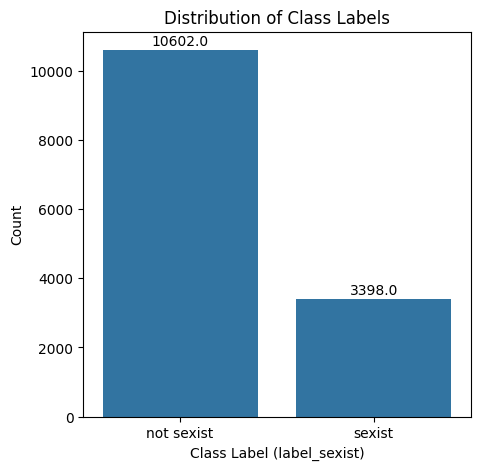

In [ ]:
# Observando o desbalanceamento de classes
plt.figure(figsize=(5, 5))
ax = sns.countplot(x='label_sexist', data=df)
plt.title('Distribution of Class Labels')
plt.xlabel('Class Label (label_sexist)')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 6), textcoords='offset points')

plt.show()

#### Conclusões da exploração dos dados de treino:

- Não há registros nulos nos textos ou na variável target;

- É notável o desbalanceamento das classes. Os textos não sexistas compõem cerca de 75% das amostras de treino.

### Processando os textos
- A função clean_text, definida anterormente, serve para pré-processar os textos.
- Esta função encapsula os processos de: retirada de caracteres especiais; tokenização com a biblioteca NLTK, remoção das stopwords e lematização.
- As saídas da função serão duas Series do pandas contendo a lista de tokens de cada texto e o texto limpo, obtido fazendo um .join() nessa lista de tokens.
- Após a aplicação dessa função, será criada uma nova coluna do DataFrame chamada "target. Essa variável é um mapeamento da variável "label_sexist". a classe "not_sexist" será mapeada para 0 e a classe "sexist" será mapeada para 1.


In [ ]:
# Aplicando o pré-processamento definido anteriormente
df[['tokenized_text', 'clean_text']] = df['text'].apply(clean_text)

# Removendo os textos limpos que ficaram com apenas um token
df = df[df['clean_text'].str.len() > 1]

# Como ficou combinado no início do trabalho, O texto sexista será classificado
# como 1. sendo assim, A sensibilidade é uma métrica importante pois é
# diretamente impactada pelos falsos negativos, ou seja, textos que SÃO
# sexistas, mas que foram classificados como NÃO sexistas.
df['target'] = df['label_sexist'].apply(lambda x: np.uint(0) if x == 'not sexist' else np.uint(1))
df[['text','tokenized_text','clean_text','label_sexist','target']].head()

,text,tokenized_text,clean_text,label_sexist,target
0,"Then, she's a keeper. 😉","[she, keeper]",she keeper,not sexist,0
1,This is like the Metallica video where the poo...,"[like, metallica, video, poor, mutilated, bast...",like metallica video poor mutilated bastard sa...,not sexist,0
2,woman?,[woman],woman,not sexist,0
3,Unlicensed day care worker reportedly tells co...,"[unlicensed, day, care, worker, reportedly, te...",unlicensed day care worker reportedly tell cop...,not sexist,0
4,[USER] Leg day is easy. Hot girls who wear min...,"[user, leg, day, easy, hot, girl, wear, minisk...",user leg day easy hot girl wear miniskirt get ...,sexist,1


#### Calculando e visualizando o número de palavras nos textos antes e depois do processamento

é possível que exista alguma diferença significativa entre as classses na quantidade de palavras de cada texto.

Para a visualização escolhi o "boxplot", pois esse gráfico consegue trazer muitas informações condensadas em uma visualização relativamente simples.

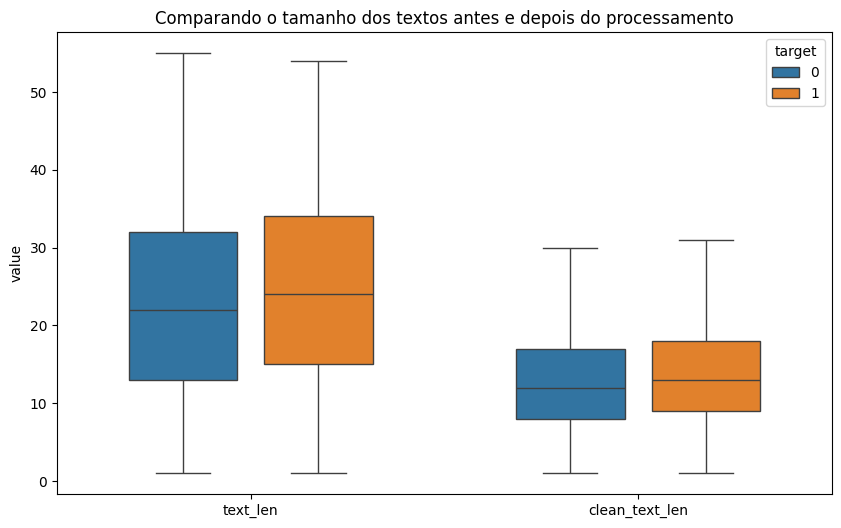

In [ ]:
# Calculando o número de palavras por texto antes e depois do processamento
# dos dados

df['text_len'] = df['text'].apply(lambda x: len(x.split()))
df['clean_text_len'] = df['clean_text'].apply(lambda x: len(x.split()))

# visualizando características dos textos de cada classe
plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', hue='target', data=pd.melt(df, id_vars=['target'], value_vars=['text_len', 'clean_text_len']), width=0.7, gap=0.2, showfliers=False)
plt.title('Comparando o tamanho dos textos antes e depois do processamento')
plt.xlabel('') # Remove x-axis label
plt.show()

A partir da visualização acima, é perceptível que ambas as categorias apresentam quantidades parecidas de palavras. Apenas uma pequena tendência de textos maiores na classe 1 (texto sexista).  

A seguir vou calcular esta diferença.

In [ ]:
# calculando essa diferença
print('mediana do número de palavra dos textos originais',
      df.groupby('target')['text_len'].median())
print()
print('mediana do número de palavra dos textos processados',
      df.groupby('target')['clean_text_len'].median())

mediana do número de palavra dos textos originais target
0    22.0
1    24.0
Name: text_len, dtype: float64

mediana do número de palavra dos textos processados target
0    12.0
1    13.0
Name: clean_text_len, dtype: float64


Contagem da frequência de palavras em cada classe

In [ ]:
# Calculando a frequência de palavras nos textos de cada classe
contagem_classe_0, contagem_classe_1 = conta_palavras(df=df, coluna='clean_text')

print(contagem_classe_0.most_common()[:10])
print()
print(contagem_classe_1.most_common()[:10])

[('woman', 2641), ('url', 1552), ('like', 1271), ('girl', 1228), ('get', 909), ('user', 810), ('would', 718), ('one', 703), ('want', 625), ('men', 594)]

[('woman', 1733), ('men', 507), ('like', 499), ('bitch', 489), ('get', 426), ('girl', 327), ('female', 288), ('would', 248), ('want', 243), ('fuck', 241)]


As classes apresentam número de textos distintos, portanto o número de vezes que cada palavra aparece não traz informações relevantes.

A verdadeira informação que estas listas contém é a posição que cada palavra ocupa.

Palavras agressivas e/ou de insulto como "bitch" e "fuck" passam a aparecer na lista das mais frequentes nos textos sexistas (classe 1). Além disso, é interessante perceber o uso da palavra "female" que indica ênfase no sexo biológico.

## Machine Learning

#### Definindo parâmetros gerais para nortear o treinamento dos modelos de ML
- SEED se refere ao número passado para a função geradora de números aleatórios. Utilizar um número padrão garante a reprodutibilidade dos experimentos.

- X se refere ao conjunto de variáveis explicativas, nesse caso os textos.

- y se refere ao conjunto de variáveis resposta (target), 0 ou 1.

- classificadores é um dict do python. as chaves são o nome que atribuí a cada algoritmo de ML. Os valores são o objeto instanciado dos respectivos algoritmos com seus hiperparâmetros. Inicialmente escolhi utilizar o mínimo de hiperparâmetros possível.

- df_resultados é o DataFrame pandas no qual serão registrados os valores das métricas de cada um dos modelos e pipelines experimentadas.

- Inicialmente não irei utilizar validação cruzada. Apesar de ser um recurso muito importante, na fase inicial não será utilizada para economizar tempo e recurso computacional.

A ideia aqui é treinar e testar os algoritmos apenas com os dados de treino (train.csv)

In [ ]:
# Definição de parâmetros em geral

# Definindo a seed do gerador de números aleatórios
SEED = 144

# Definindo as variáveis utilizadas
X = df['clean_text']
y = df['target']

# Instanciando os classificadores usados na pipeline e definindo parâmetros.
classificadores = {
    'rl': LogisticRegression(random_state=SEED),
    'rf': RandomForestClassifier(max_depth=2, random_state=SEED,
                                 class_weight='balanced'),
    'nb': MultinomialNB(),
    'svc': SVC(kernel='linear', random_state=SEED),
    'xgb': XGBClassifier(seed=SEED)}

# Definindo onde os resultados serão registrados
df_resultados = pd.DataFrame()

Considerando 1400 mil amostras, sendo 30% para teste teremos 4200 amostras no subconjunto de teste.

#### Usando os dados originais (base)

In [ ]:
# Rodando a pipeline com os dados base
df_resultados = pipeline_base(classificadores=classificadores,
                              df_resultados=df_resultados,
                              X=X,
                              y=y)
df_resultados

,algoritmo,acurácia,f1-score_0,f1-score_1,matriz_confusao,tn,fp,fn,tp
0,rl_base,0.822619,0.893647,0.465950,"[[3130, 51], [694, 325]]",3130,51,694,325
1,rf_base,0.769762,0.847788,0.527601,"[[2693, 488], [479, 540]]",2693,488,479,540
2,nb_base,0.784524,0.875052,0.217805,"[[3169, 12], [893, 126]]",3169,12,893,126
3,svc_base,0.844048,0.905251,0.559516,"[[3129, 52], [603, 416]]",3129,52,603,416
4,xgb_base,0.835000,0.898994,0.549708,"[[3084, 97], [596, 423]]",3084,97,596,423


#### Conclusções do uso dos dados originais
- Resultados ruins em relação à classe 1. Destaque para o alto número de falsos negativos, nossa métrica mais importante.
- Hipótese: O resultado obtido é fortemente influenciado pelo desbalanço na variável target. há muito mais exemplos de texto não sexista.
para avaliar essa hipótese torna-se necessário fazer o balanceamento de classes.

### Balanceamento de classes

#### Balanceamento por undersampling
- A ideia desse método é igualar o número de registros de cada classe reduzindo os exemplos da classe com maior representação, chamada de classe majoritária. Nesse caso, irei reduzir o número de exemplos de textos classificados como não sexistas.
- O efeito colateral mais óbvio da aplicação desse método é a perda de informação, já que descartam-se dados da base utilizada.

#### demonstração da aplicação de undersampling utilizando o algoritmo random_undersampling da biblioteca imblearn.



In [ ]:
# separando treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
X_train = X_train.to_frame()
y_train = y_train.to_frame()

# instanciando o undersampler e processando os dados.
# Importante! o parâmetro sampling_startegy define qual a proporção entre
# as classes. nesse caso utiliza-se 'majority' para igualar os números reduzindo
# apenas o número de registros da classe majoritária.
random_undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=SEED)

# aplicando o undersample apenas nos dados de treino
X_under_train, y_under_train = random_undersampler.fit_resample(X_train, y_train)

# exibindo os tamanhos dos vetores antes e após o undersampling aleatório
print('Número de registros nos dados de treino originais', y_train.value_counts())
print()
print('Número de registros nos dados de treino com undersampling', y_under_train.value_counts())
print()
print('Após o undersampling o número de registros de cada classe é igual.')

Número de registros nos dados de treino originais target
0         7421
1         2379
Name: count, dtype: int64

Número de registros nos dados de treino com undersampling target
0         2379
1         2379
Name: count, dtype: int64

Após o undersampling o número de registros de cada classe é igual.


#### Treinando os modelos com os dados balanceados por undersampling

In [ ]:
# Rodando a Pipeline com undersampling
df_resultados = pipeline_undersampler(classificadores=classificadores,
                              df_resultados=df_resultados,
                              X=X,
                              y=y)
df_resultados[df_resultados['algoritmo'].str.endswith("under")]

,algoritmo,acurácia,f1-score_0,f1-score_1,matriz_confusao,tn,fp,fn,tp
5,rl_under,0.776429,0.844614,0.601612,"[[2552, 629], [310, 709]]",2552,629,310,709
6,rf_under,0.742857,0.819820,0.551122,"[[2457, 724], [356, 663]]",2457,724,356,663
7,nb_under,0.679762,0.757089,0.530213,"[[2096, 1085], [260, 759]]",2096,1085,260,759
8,svc_under,0.759286,0.830511,0.584805,"[[2477, 704], [307, 712]]",2477,704,307,712
9,xgb_under,0.778333,0.844392,0.614812,"[[2526, 655], [276, 743]]",2526,655,276,743


#### Conclusções do balanceamento por undersampling
- Pode-se notar uma troca, um trade-off, em relação às métricas. Os resultados de falsos negativos foram reduzidos, porém os verdadeiros negativos também, ou seja, os modelos conseguiram aprender melhor os padrões da classe 1. Em troca disso, pela redução de exemplos da classe 0, os modelos erram relativamente mais nessas predições.
- O aumento drástico de falsos positivos corrobora com as colocação anterior.

#### Balanceamento por Oversampling
- A ideia desse método é aproximar o número de registros das classes aumentando os exemplos das classes com menor representação. Nesse caso, irei aumemtar o número de registros classificados como não sexistas através da geração de dados sintéticos.
- Alguns possíveis efeitos adversos da aplicação desse método são: aumento da possibilidade de overfitting por conta da inserção de dados "parecidos" com os já presentes; reduzir a definição da fronteira de decisão dos algoritmos por conta do acréscimo de dados "muito próximos" uns dos outros.

#### demonstração da aplicação de oversampling utilizando o algoritmo SMOTE da biblioteca imblearn

- Nesse algoritmo o parâmetro "sampling strategy" definido como 0.8 significa que a razão final entre os números totais da classe minoritária e majoritária será de 0.8, ou seja, a classe minoritária deve ter 80% do número de registros da clase majoritária.

In [ ]:
# Definindo o algoritmo de oversampling e seus parâmetros.
smote_oversampler = SMOTE(sampling_strategy=0.8, random_state=SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

# definindo o algoritmo de vetorização
vectorizer_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Vetorizando os textos processados (dados de treino e teste)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# Aplicando oversampling nos dados de treino com SMOTE
X_over_train_tfidf, y_over_train_tfidf = smote_oversampler.fit_resample(X_train_tfidf, y_train)

print('tamanho do y_train antes do oversampling: ', y_train.value_counts())
print()
print('Número de registros nos dados de treino após o oversampling: ', y_over_train_tfidf.value_counts())
print()
print('Após o oversampling o número de registros da classe 1 aumenta.')
print('Agora a razão entre classe 1 e 0 é de 0.8 como foi estupulado')

tamanho do y_train antes do oversampling:  target
0    7421
1    2379
Name: count, dtype: int64

Número de registros nos dados de treino após o oversampling:  target
0    7421
1    5936
Name: count, dtype: int64

Após o oversampling o número de registros da classe 1 aumenta.
Agora a razão entre classe 1 e 0 é de 0.8 como foi estupulado


#### Treinando os modelos balanceados por oversampling usando SMOTE

In [ ]:
# Rodando a Pipeline com oversampling
df_resultados = pipeline_oversampler(classificadores=classificadores,
                              df_resultados=df_resultados,
                              X=X,
                              y=y)
df_resultados[df_resultados['algoritmo'].str.endswith("over")]

,algoritmo,acurácia,f1-score_0,f1-score_1,matriz_confusao,tn,fp,fn,tp
10,rl_over,0.824048,0.885763,0.617297,"[[2865, 316], [423, 596]]",2865,316,423,596
11,rf_over,0.749048,0.834537,0.480788,"[[2658, 523], [531, 488]]",2658,523,531,488
12,nb_over,0.770000,0.847922,0.528320,"[[2693, 488], [478, 541]]",2693,488,478,541
13,svc_over,0.804286,0.870958,0.595074,"[[2774, 407], [415, 604]]",2774,407,415,604
14,xgb_over,0.832381,0.895950,0.569155,"[[3031, 150], [554, 465]]",3031,150,554,465


#### Conclusções do balanceamento por Oversampling usando SMOTE
- Com a utilização de oversampling com SMOTE observa-se o aumento das métricas Sensibilidade e, consequentemente, do F1-score. Houve um ganho considerável na qualidade das predições de positivos com uma perda reduzida ou nula de qualidade nas predições de negativos. O F1-score da regressão logística para a classe 0 se manteve em 0.89 nos dados originais e oversampling.
- Este f1-score reflete a redução significativa nos falsos negativos caindo de 694 nos dados originais para 423 nos dados com oversampling.


### Exibindo o DataFrame de resultados com as métricas de cada uma das pipelines.

In [ ]:
# Exibindo o DataFrame de resultados completo
df_resultados

,algoritmo,acurácia,f1-score_0,f1-score_1,matriz_confusao,tn,fp,fn,tp
0,rl_base,0.822619,0.893647,0.465950,"[[3130, 51], [694, 325]]",3130,51,694,325
1,rf_base,0.769762,0.847788,0.527601,"[[2693, 488], [479, 540]]",2693,488,479,540
2,nb_base,0.784524,0.875052,0.217805,"[[3169, 12], [893, 126]]",3169,12,893,126
3,svc_base,0.844048,0.905251,0.559516,"[[3129, 52], [603, 416]]",3129,52,603,416
4,xgb_base,0.835000,0.898994,0.549708,"[[3084, 97], [596, 423]]",3084,97,596,423
5,rl_under,0.776429,0.844614,0.601612,"[[2552, 629], [310, 709]]",2552,629,310,709
6,rf_under,0.742857,0.819820,0.551122,"[[2457, 724], [356, 663]]",2457,724,356,663
7,nb_under,0.679762,0.757089,0.530213,"[[2096, 1085], [260, 759]]",2096,1085,260,759
8,svc_under,0.759286,0.830511,0.584805,"[[2477, 704], [307, 712]]",2477,704,307,712
9,xgb_under,0.778333,0.844392,0.614812,"[[2526, 655], [276, 743]]",2526,655,276,743


### Conclusões do balanceamento de classes
- Ao obter resultados melhores evidenciados pelas métricas discutidas anteriormente, posso valdiar a hipótese levantada no início dessa seção. Os resultados não satisfatórios dos primeiros modelos eram fortemente influenciados pelo desbalanceamento das classes nos dados de treino.

## explorando os dados de teste

In [ ]:
# Observando os dados e a razão no número de registros de cada classe.
df_teste = pd.read_csv('test.csv')

print('número total de registros', df_teste.shape[0])
print('número de registros das classes 0 e 1: ', df_teste['label_sexist'].value_counts(normalize=False).values)
print('razão entre classes 0 e 1: ', df_teste['label_sexist'].value_counts(normalize=True).values)

df_teste.sample(5, random_state=SEED)

número total de registros 4000
número de registros das classes 0 e 1:  [3030  970]
razão entre classes 0 e 1:  [0.7575 0.2425]


,rewire_id,text,label_sexist,label_category,label_vector,split
549,sexism2022_english-11056,Whoopi is blinded by her ideaolgy and it feeds...,not sexist,none,none,test
3026,sexism2022_english-4985,"I'm sorry, where was the mention of one of the...",not sexist,none,none,test
995,sexism2022_english-10385,guess all those conservatives still think she ...,not sexist,none,none,test
3400,sexism2022_english-13155,Not to mention they want to lockdown that beta...,not sexist,none,none,test
2037,sexism2022_english-580,"What is there to think about? Kill her, kill t...",sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm,test


Ao analsar os dados acima, observo que os criadores desse conjunto de dados tiveram o cuidado de manter a proporção entre classes aproximadamente a mesma nos conjuntos de treino e de teste. Este é um fator importante por que reduz uma variável, facilitando a análise dos resultados.

Em seguida irei utilizar o mesmo pré-processamento aplicado aos dados de treino.

É importante manter o mesmo padrão para obter a melhor performance domodelo treinado.

In [ ]:
# Aplicando o pré-processamento definido anteriormente
df_teste[['tokenized_text', 'clean_text']] = df_teste['text'].apply(clean_text)

df_teste['target'] = df_teste['label_sexist'].apply(lambda x: np.uint(0) if x == 'not sexist' else np.uint(1))
df_teste[['text','tokenized_text','clean_text','label_sexist','target']].sample(5, random_state=SEED)

,text,tokenized_text,clean_text,label_sexist,target
549,Whoopi is blinded by her ideaolgy and it feeds...,"[whoopi, blinded, her, ideaolgy, feed, her, ha...",whoopi blinded her ideaolgy feed her hatred co...,not sexist,0
3026,"I'm sorry, where was the mention of one of the...","[sorry, mention, one, girl, relevant, trying, ...",sorry mention one girl relevant trying dick un...,not sexist,0
995,guess all those conservatives still think she ...,"[guess, conservative, still, think, she, got, ...",guess conservative still think she got elected...,not sexist,0
3400,Not to mention they want to lockdown that beta...,"[mention, want, lockdown, beta, cuck, provider...",mention want lockdown beta cuck provider coupl...,not sexist,0
2037,"What is there to think about? Kill her, kill t...","[think, kill, her, kill, friend, dump, atlanti...",think kill her kill friend dump atlantic ocean...,sexist,1


VIsualizando algumas características dos dados de teste

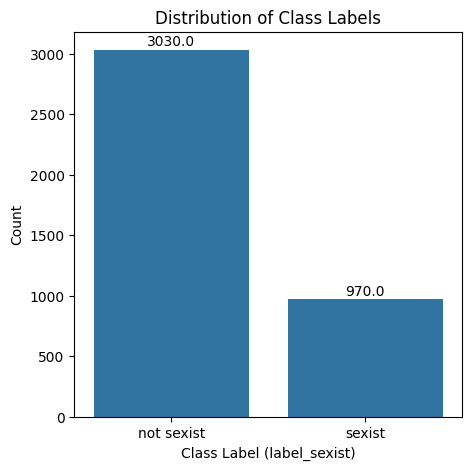

In [ ]:
# Observando o desbalanceamento de classes
plt.figure(figsize=(5, 5))
ax = sns.countplot(x='label_sexist', data=df_teste)
plt.title('Distribution of Class Labels')
plt.xlabel('Class Label (label_sexist)')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 6), textcoords='offset points')

plt.show()

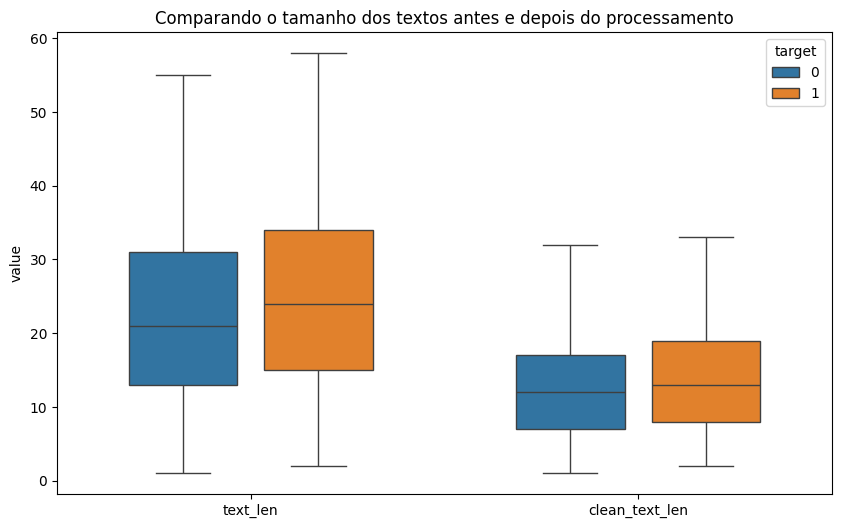

In [ ]:
# Calculando o número de palavras por texto antes e depois do processamento
# dos dados

df_teste['text_len'] = df_teste['text'].apply(lambda x: len(x.split()))
df_teste['clean_text_len'] = df_teste['clean_text'].apply(lambda x: len(x.split()))

# visualizando características dos textos de cada classe
plt.figure(figsize=(10, 6))
sns.boxplot(x='variable', y='value', hue='target', data=pd.melt(df_teste, id_vars=['target'], value_vars=['text_len', 'clean_text_len']), width=0.7, gap=0.2, showfliers=False)
plt.title('Comparando o tamanho dos textos antes e depois do processamento')
plt.xlabel('') # Remove x-axis label
plt.show()

In [ ]:
print('mediana do número de palavra dos textos originais',
      df_teste.groupby('target')['text_len'].median())
print()
print('mediana do número de palavra dos textos processados',
      df_teste.groupby('target')['clean_text_len'].median())

mediana do número de palavra dos textos originais target
0    21.0
1    24.0
Name: text_len, dtype: float64

mediana do número de palavra dos textos processados target
0    12.0
1    13.0
Name: clean_text_len, dtype: float64


Os dados de teste respeitam os padrões encontrados nos dados de treino.

## Machine Learning com dados de teste

#### Definições desta sessão.

- A experimentação agora aconteccerá com a modificação dos hiperparâmetros dos modelos escolhidos.

-  é importante notar que os modelos escolhidos serão agora treinados com todo o conjunto de dados de treino e testados com todo o conjunto de dados de teste. Isso, em tese, irá melhorar a classificação destes modelos, pois representa um aumento dos dados de treino. Também dá mais credibilidade para os resultados dos testes.

- A partir dos resultados vistos anteriormente escolhi o Oversample com SMOTE como a técnica de balanceamento de classes a ser utilizada.



In [ ]:
# definindo os dados para teste
# cinjunto de dados de treino
X_treino = df['clean_text']
y_treino = df['target']

# cinjunto de dados de teste
X_teste = df_teste['clean_text']
y_teste = df_teste['target']


df_resultados_teste = pd.DataFrame()

In [ ]:
# Rodando a Pipeline de teste
df_resultados_teste = pipeline_oversampler_teste(classificadores=classificadores,
                              df_resultados=df_resultados_teste,
                              X_treino=X_treino,
                              y_treino=y_treino,
                              X_teste=X_teste,
                              y_teste=y_teste)

df_resultados_teste[df_resultados_teste['algoritmo'].str.endswith("over")]

,algoritmo,acurácia,f1-score_0,f1-score_1,matriz_confusao,tn,fp,fn,tp
0,rl_over,0.82000,0.881851,0.622246,"[[2687, 343], [377, 593]]",2687,343,377,593
1,rf_over,0.78050,0.855687,0.541754,"[[2603, 427], [451, 519]]",2603,427,451,519
2,nb_over,0.78325,0.855428,0.567149,"[[2565, 465], [402, 568]]",2565,465,402,568
3,svc_over,0.81000,0.873376,0.619620,"[[2621, 409], [351, 619]]",2621,409,351,619
4,xgb_over,0.83950,0.899875,0.595718,"[[2885, 145], [497, 473]]",2885,145,497,473


Os três melhores modelos foram escolhidos com base no f1-score e na quantidade de falsos negativos.

São eles: SVC, Regressão Logística e Naive Bayes.

Estes algoritmos serão avaliados novamente, desta vez com variação de hiperparâmetros.

Em relação a testes com hiperparâmetros algumas opções estão disponíveis "out of the box". Trago uma breve explicação de duas delas.
- GridSearch:  Abordagem que propõe testar todas as combinações dos hiperparâmetros pré-definidos. Seu ponto forte é a garantia do resultado ótimo, pois testa de forma exaustiva as combinações possíveis. Seu ponto fraco é o alto custo computacional e consequentemente grande consumo de tempo.

- RandomSearch: Abordagem que propõe testar um número pré-definido de combinações entre os hiperparâmetros, que também são definidos pelo usuário. O algoritmo escolhe de maneira pseudorandômica quais combinações serão testadas. Seu ponto forte é reduzir consideravelmente o custo computacional, além disso permite ao usuário escolher quantas amostras serão testadas, portante personalizar seu experimento. Seu ponto fraco é que não há nenhuma garantia de otimização de resultado já que seu processo é estocástico.

Opto pelo algoritmo de RandomizedSearch, por possibilitar o atingimento de bons resultados sem o custo total requerido pelo GridSearch. Abaixo estarão os experimentos com os três algoritmos escolhidos.


### Tunagem de hiperparâmetros com RandomizedSearch
- Para avaliar o resultado das combinações de hiperparâmetros, defini a utilização de validação cruzada. Nesse momento tenho menos algoritmos sendo testados, ou seja, essa operação terá menos custo computacional. Além disso preciso de resultados mais confiáveis para definir com mais clareza o algoritmo mais adequado.

- Ao final desse notebook deixo uma sessão mais aprofundada sobre os hiperparâmetros utilizados em cada um dos três algoritmos testados.

- OBS.: Processo separado em células diferentes, pois há alto consomo de tempo.

In [ ]:
# listando so classificadores selecionados
classificadores_selecionados = [SVC(random_state=SEED), LogisticRegression(random_state=SEED), MultinomialNB()]

# Definindo os parâmetros de entrada do RandomizedSearch para cada classificador
rl_parametros = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200],
    'tol': [1e-4, 1e-3, 1e-2],
    'class_weight': [None, 'balanced']
}

svm_parametros = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1],
    'class_weight': [None, 'balanced'],
}

nb_parametros = {
    'alpha': [0.01, 0.1, 1, 10],
    'fit_prior': [True, False],
    'class_prior': [None, [0.2, 0.8], [0.5, 0.5]],
}

# Listas que vão receber os modelos com as melhores
# combninações de hipeparâmetros
melhores_modelos = list()
melhores_parametros = list()

1 - RandomizedSearch do algoritmo SVM

In [ ]:
# Rodando a busca aleatória pela melhor combinação de hiperparâmetros do SVM
melhor_parametro, melhor_modelo = randomized_search_alt(classificador=classificadores_selecionados[0],
                                                    parametros=svm_parametros,
                                                    n_testes=50,
                                                    X=X_treino,
                                                    y=y_treino)

melhores_modelos.append(melhor_modelo)
melhores_parametros.append(melhor_parametro)
print(melhor_modelo)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
SVC(C=1, class_weight='balanced', gamma=0.1, random_state=144)


2 - RandomizedSearch do algoritmo Regressão Logística

In [ ]:
# Rodando a busca aleatória pela melhor combinação de hiperparâmetros da rl
melhor_parametro, melhor_modelo = randomized_search_alt(classificador=classificadores_selecionados[1],
                                                    parametros=rl_parametros,
                                                    n_testes=100,
                                                    X=X_treino,
                                                    y=y_treino)

melhores_modelos.append(melhor_modelo)
melhores_parametros.append(melhor_parametro)
print(melhor_modelo)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
LogisticRegression(C=1.623776739188721, class_weight='balanced', penalty='l1',
                   random_state=144, solver='liblinear', tol=0.001)


3 - RandomizedSearch do algoritmo Naive Bayes

In [ ]:
# Rodando a busca aleatória pela melhor combinação de hiperparâmetros da nb
melhor_parametro, melhor_modelo = randomized_search_alt(classificador=classificadores_selecionados[2],
                                                    parametros=nb_parametros,
                                                    n_testes=100,
                                                    X=X_treino,
                                                    y=y_treino)

melhores_modelos.append(melhor_modelo)
melhores_parametros.append(melhor_parametro)
print(melhor_modelo)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 24 candidates, totalling 96 fits
MultinomialNB(alpha=1, fit_prior=False)


In [ ]:
# Modelos selecionados pelo RandomizedSearch:
# SVC(C=1, class_weight='balanced', gamma=0.1, random_state=144)
# LogisticRegression(C=1.623776739188721, class_weight='balanced', penalty='l1',
#                   random_state=144, solver='liblinear', tol=0.001)
# MultinomialNB(alpha=1, fit_prior=False)


# Obtendo os modelos com os hiperparâmetros da lista de resultados
SVC_random, rl_random, nb_random = melhores_modelos

# criando o DataFrame para receber os resultados dos modelos tunados
df_resultados_random = pd.DataFrame()

# dict com os modelos (classificadores) definidos com os hiperparâmetros
# encontrados através de RandomizedSearch
classificadores_random = {'svc_tunado': SVC_random,
                          'rl_tunado': rl_random,
                          'nb_tunado': nb_random,
}

# Treinando os modelos com todo o conjunto de dados de treino e testando-os
# com todos os dados de teste.
df_resultados_random = pipeline_oversampler_teste(classificadores=classificadores_random,
                              df_resultados=df_resultados_random,
                              X_treino=X_treino,
                              y_treino=y_treino,
                              X_teste=X_teste,
                              y_teste=y_teste)

df_resultados_random

,algoritmo,acurácia,f1-score_0,f1-score_1,matriz_confusao,tn,fp,fn,tp
0,svc_tunado_over,0.82650,0.890502,0.582431,"[[2822, 208], [486, 484]]",2822,208,486,484
1,rl_tunado_over,0.82000,0.879032,0.648438,"[[2616, 414], [306, 664]]",2616,414,306,664
2,nb_tunado_over,0.73725,0.812288,0.562266,"[[2274, 756], [295, 675]]",2274,756,295,675


## Considerações finais

- O algoritmo que obteve o melhor desempenho nos testes foi a Regressão Logística. Embora o algoritmo Naive Bayes tenha atingido o menor número de falsos negativos ("fn"), a diferença foi pequena, portanto esse não será um critério de diferenciação.

- A Regressão Losgística é consiederado um algoritmo simples de classificação. Nesse caso, obteve resultados superiores aos dos algoritmos mais complexos. Com a tunagem de hiperparâmetros, o algoritmo aprimorou sua classificação para ambas as classes.

- Em relação ao SVC. Este obteve o melhor resultado para a classe majoritária 0, ou seja, o algoritmo conseguiu "aprender" muito bem os padrões desta classe, porém obteve resultado inferior aos dos demais algoritmos para a classe majoritária. Outro critério de desclassificação pode ser o seu tempo de treino e de predição, que são mais altos do que os de seus "adversários".

- Pela minha análise, não houve Overfitting nem Underfitting. Considero que o problema proposto é suficientemente complexo para os algoritmos utilziados, dificultando a possibilidade de overfitting. Entendo também que abordagens utilizando redes neurais ou mesmo tranformadores como BERT trariam a possibilidade de resultados melhores. A escolha de utilizar aprendizado de máquina "clássico" teve um intuito exploratório.

- É importante lembrar que o teste dos hiperparâmetros foi através do algoritmo RandomizedSearch, que não garante um resultado ótimo (erro mínimo global). Portanto o resultado pode ser outro a depender da combinação desses parâmetros. Além disso, o algoritmo foi definido para utilizar o f1-score como "macro", que calcula uma média do f1-score de cada classe, isso explica por que alguns resultados dessa métrica para a classe 1 com especificação de hiperparâmetros ficaram "piores" do que quando não foram especificados parâmetros.

## Possibilidades não esxploradas:
##### 01. Uma abordagem possível, e não exploada, para o problema de desbalanceamento de classes é utilizar ensembles. Essa abordagem pode seguir dois princípios diferentes:
- A primeira ideia é treinar os vários algoritmos do ensamble em pequenas parcelas dos dados, isso possibilita que os dados sejam observados por completo, porém em lotes balanceados. A classificação final pode ser uma votação entre os algoritmos. Utiliza o conceito de Bagging.
- A segunda ideia se baseia em utilizar algoritmos que possuem a capacidade intrínseca de reforçar o aprendizado com foco na classe com mais erros de predição. Dessa forma, o algoritmo foca o aprendizado na classe minoritária. O conceito por trás dessa abordagem é o Boosting.


##### 02. O tempo de predição também é uma métrica que pode ser crítica em um caso de classificação de texto. Um exemplo claro de diferenças no tempo de predição foi encontrado nesse trabalho. Os algoritmos MultinomialNB e SVC possuem tempos de predição bastante diferentes. Se o produto a ser desenvolvido precisar de agilidade pode ser necessária uma troca entre qualidade e velocidade da predição. Casos assim são bastante comuns.

##### 03. Diferentes métodos de tokenização ou mesmo de vetorização dos textos poderiam ser comparados na resolução do problema proposto.

## Seção Extra: Hiperparâmetros

- Regressão Logística:

 - penalty: Define a regularização utilizada. As possibilidades são nenhuma, L1, L2 ou a combinação de L1 e L2. Na prática, a ergularização impõe limites aos modelos, dificultando sua adequação aos dados de treino e consequentemente tornando-os menos propensos ao overfitting. A regularização L1, chamada de "Lasso", também possui a capacidade de selecionar atributos, o que pode tornar o modelo mais simples e interpretável.

 - C: indica o inverso dom peso da regularização. Quanto maior o C, menor será o efeito da regularização definida para esse algoritmo.

 - solver: Define o algoritmo de otimização, ou seja, a função que tenta diminuir os erros de predição do modelo.

 - max_iter: Número máximno de iterações que o algoritmo fará para ajustar seus parâmetros.

 - tol: Tolerância do critério de parada do algoritmo. Na prática, define o quão perto do erro mínimo o algoritmo tenta chegar.

  - class_weight: quando definido como "balanced" atribui maiores pesos às classes com menor número de registros no conjunto de dados.

- SVM (SVC):

 - C: Parâmetro de penalização do termo de erro do modelo. Na prática esse termo representa uma barganha entre precisão na classificação e suavidade da superfície de decisão. Quanto mais alto o C, mais o modelo irá ajustar a superfície de decisão aos dados de treinamento, podendo dessa forma levar o modelo ao overfitting (superadequação).

 - gamma: Parâmetro que dita a formação do hiperplano. Quanto maior o valor do gamma, maior será a adequação do hiperplano aos dados de treinamento, portanto pode levar o modelo ao overfitting. Esse parâmetro recebe "auto", "scale" ou um float. Na opção "auto" o valor é calculado como: (1 / número de features).

 - kernel: O kernel define o tipo de hiperplano a ser utilizado para a separação dos dasos. O parâmetro dita o kernel dentre as seguintes as opções: "linear", "poly", "rbf", "sigmoid", "precomputed" ou uma função arbitrária. Como o nome sugere, o kernel linear representa uma reta em um espaço 2D, os demais são não-lineares. Ao utilizar o kernel como "poly" pode-se também definir o hiperparâmetro "degree" que indica o grau do polinômio estimado, sendo seu falor padrão igual a 3.

- Naive Bayes (MultinomialNB):

 - alpha: Fator de suavização (smoothing). Na prática o alpha atribui uma probabilidade minimamente significativa para eventos com probabilidades muito próximas a zero, essas causariam perda de dados potencialmente valiosos. Quanto maior o alpha, maior o efeito de suavização.

 - fit_prior: Define se o algoritmo irá aprender as probabilidades das classes a partir das razões entre o número de registros de cada classe nos dados. Caso a razão entre as classes já seja conhewcida não há necessidade da utilização desse hiperparâmetro

 - class_prior: Define manualmente as probabilidades a priori das classes. Utilizado caso essas probabilidades sejam conhecidas e não estejam bem representadas no conjunto de dados.